In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
rng = np.random.default_rng()

## chapter 2
### 1. 
use the rate given by equation 2.1 with $r_0$ = 50Hz and
$$
D(\tau) = -\cos(\frac{2\pi(\tau - 20 \text{ms} )}{140\text{ms}})\exp(-\frac{\tau}{60\text{ms}}) \text{Hz/ms}
$$

to predict the response of a neuron of the electrosensory lateral-line lobe to a stimulus
- above equation is an approximation for the linear kernel obtained from the STA in fig 1.9
- use approximate gaussian white noise stimulus constructed by choosing stimulus values at every 10ms ($\delta t$ = 10ms)
    - from gaussian distribution with zero mean and variance $\sigma^2_s / \delta t$ with $\sigma_s^2 = 10$
- compute firing rate over 10s  period
- from results, compare firing rate-stimulus correlation function $Q_{rs}(\tau)$ 
- using equation 2.6, compare $Q_{rs}(-\tau)/\sigma^2_s$ with kernel $D(\tau)$ given above

equation 2.1:
$r_{est}(t) = r_0 + \int_0^\infty d\tau D(\tau)s(t-\tau) $

equation 2.6:
$ D(\tau) = \frac{Q_{rs}(-\tau)}{\sigma^2_s} = \frac{\langle r \rangle C(\tau)}{\sigma^2_s} $

In [13]:
r0 = 50
dt = 10e-3
t = np.arange(0, 10, dt)
noise_std = np.sqrt(10/dt)
s = np.random.normal(0, noise_std, len(t))
kernel = -np.cos((2 * np.pi * (t - 20e-3)) / 140e-3) * np.exp(-t / 60e-3)

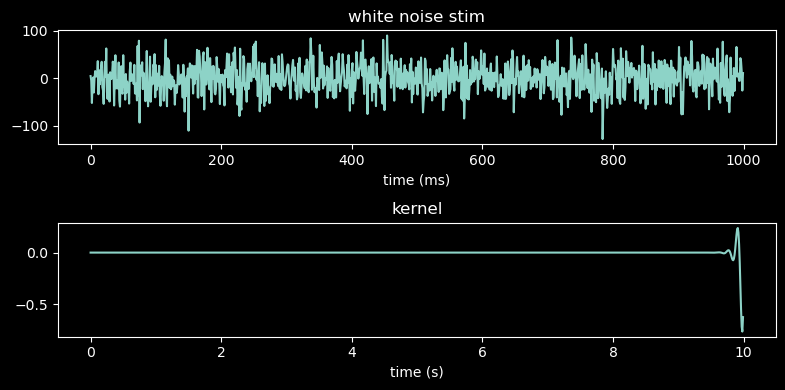

In [14]:
# check stimulus and kernel
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
ax[0].plot(s)
ax[0].set_title('white noise stim')
ax[0].set_xlabel('time (ms)')
ax[1].plot(t[::-1], kernel)
ax[1].set_title('kernel')
ax[1].set_xlabel('time (s)')

plt.tight_layout()

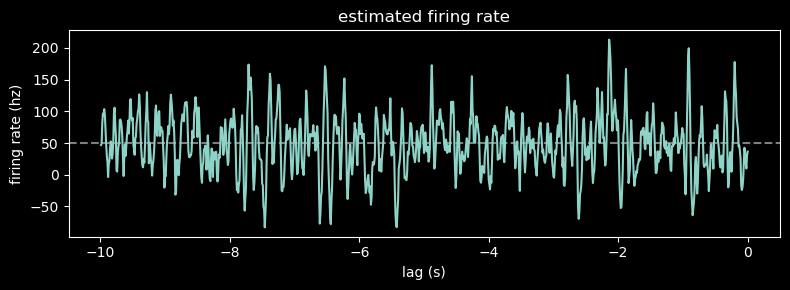

In [15]:
convolved = np.convolve(kernel, s, mode='full') + r0
lags = np.arange(-len(kernel)+1, len(kernel))*dt

fig, ax = plt.subplots(figsize=(8, 3))
ax.axhline(50, label='background firing rate', linestyle='--', alpha=0.5)
ax.plot(lags[:(int(np.ceil(len(lags)/2)))], convolved[:int(np.ceil(len(lags)/2))])
ax.set_title('estimated firing rate')
ax.set_xlabel('lag (s)')
ax.set_ylabel('firing rate (hz)')
plt.tight_layout()

In [16]:
# firing rate-stim autocorrelation 
r_est = convolved[:int(np.ceil(len(lags)/2))]
autocorr = np.correlate(s, r_est, mode='full') / (len(t))
autocorr = autocorr[:int(np.ceil(len(autocorr) / 2))] / noise_std**2

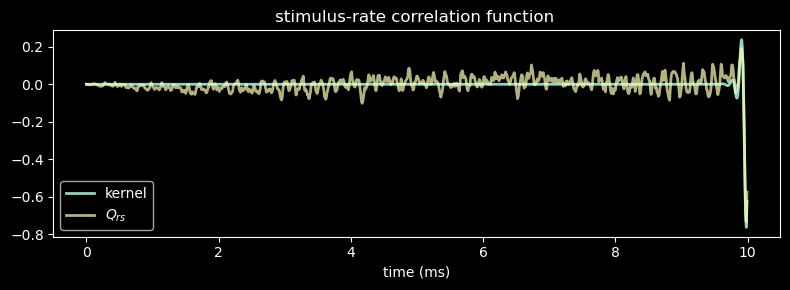

In [17]:
# good fit b/w kernel estimate and empirical autocorrelation! just noisier
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(t[::-1], kernel, label='kernel', linewidth=2)
ax.plot(t[::-1], autocorr[::-1], label='$Q_{rs}$', alpha=0.7, linewidth=2)
ax.set_title('stimulus-rate correlation function ')
ax.set_xlabel('time (ms)')
ax.legend()
plt.tight_layout()

### 2
use STA computed in c1p8 to construct a linear kernel and use it in equation 2.1 to provide a model of the response of the H1 neuron
- choose $r_0$ so that the average firing rate predicted by the model in response to the stimulus used for the data matches the actual average firing rate
- use a poisson generator with the computed rate to generate a synthetic spike train from this linear estimate of the firing rate in response to the stimulus `stim`
- plot examples of the actual and synthetic spike trains
    - how are they similar / different?
- plot autocorrelation function of actual and synthetic spike trains over range 0-100ms
    - why is there a dip at a lag of 2ms in the autocorrelation of the actual spike traim?
    - is there a dip for the synthetic train too?
- plot the ISI histogram for both spike trains
    - why is there a dip below 6ms in the actual spike train histogram?
- what are the coefficients of variation for the two spike trains and why might they differ?

In [18]:
# doing c1p8 STA again here
h1_data = pd.read_csv('C1P8.csv', header=None)
h1_data.rename(columns={0:'rho', 1:'stim'}, inplace=True)

dt8 = 2e-3
window_size = 300e-3

def get_sta(data, window_size, dt):
    window_steps = int(window_size/dt)
    sta_sum = np.zeros(window_steps)
    num_spikes = np.sum(data['rho'])
    # loop through spike train
    for i in range(window_steps, len(data['rho'])):
        # spike
        if data['rho'][i] == 1:
            # add preceding stimulus to spike-triggered sum
            sta_sum += np.asarray(data['stim'][i - window_steps:i])
    # get average of spike-triggered sum
    return sta_sum / num_spikes

sta8 = get_sta(h1_data, window_size, dt8)

In [81]:
stim_var = np.var(h1_data['stim'])
stim_mean = np.mean(h1_data['stim'])
spike_mean = np.mean(h1_data['rho']) / dt8 # Hz

equation 2.1:
$r_{est}(t) = r_0 + \int_0^\infty d\tau D(\tau)s(t-\tau) $

equation 2.6:
$ D(\tau) = \frac{Q_{rs}(-\tau)}{\sigma^2_s} = \frac{\langle r \rangle C(\tau)}{\sigma^2_s} $

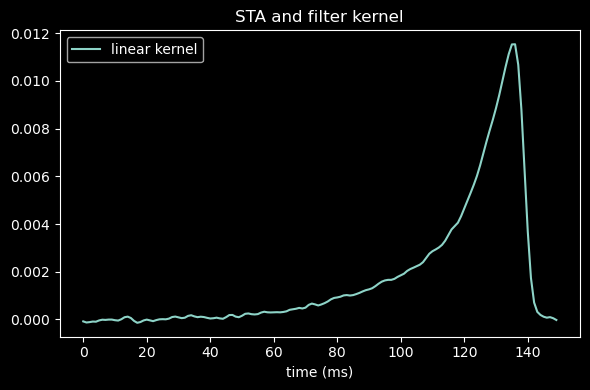

In [85]:
# pretend xticks are negative time
kernel8 = sta8 / stim_var
fig, ax = plt.subplots(figsize=(6, 4))
# ax.plot(sta8, label='h1 STA')
ax.plot(kernel8, label='linear kernel')
ax.set_title('STA and filter kernel')
ax.set_xlabel('time (ms)')
ax.legend()
plt.tight_layout()

In [123]:
r_est = np.convolve(h1_data['stim'], kernel8[::-1], mode='same')
np.mean(r_est) # want this to be ~44

-0.025550816171337754

In [124]:
#r_est += 45
syn_data = np.random.poisson(r_est * dt8)
syn_data[syn_data > 1] = 1

In [265]:
syn_times = np.where(syn_data)[0] * dt8
h1_times = np.where(h1_data['rho'])[0] * dt8

In [156]:
# mean firing rates for synthetic data and h1 data are similar
print(f'syn mean: {np.mean(r_est)}\n'
      f'real mean: {spike_mean}')

syn mean: 44.974449183828646
real mean: 44.6675


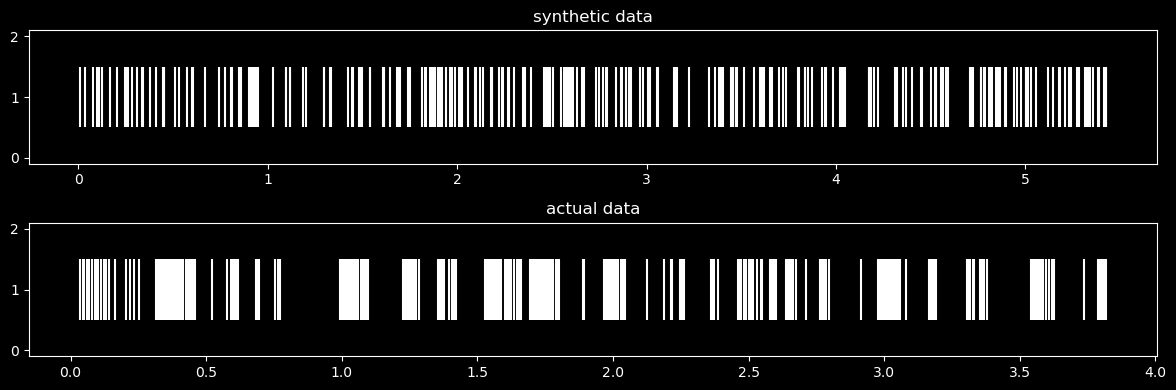

In [240]:
# spike trains are similar in that spike count rate (number of spikes / len(spike_train))
# synthetic data seems more continuous vs actual data is in groups of spikes
fig, ax = plt.subplots(2, 1, figsize=(12, 4))
ax[0].eventplot(syn_times[:250])
ax[0].set_title('synthetic data')
ax[1].eventplot(h1_times[:250])
ax[1].set_title('actual data')
plt.tight_layout()

In [192]:
actual_autocorr = np.correlate(h1_data['rho'], h1_data['rho'], mode='full')
syn_autocorr = np.correlate(syn_data, syn_data, mode='full')

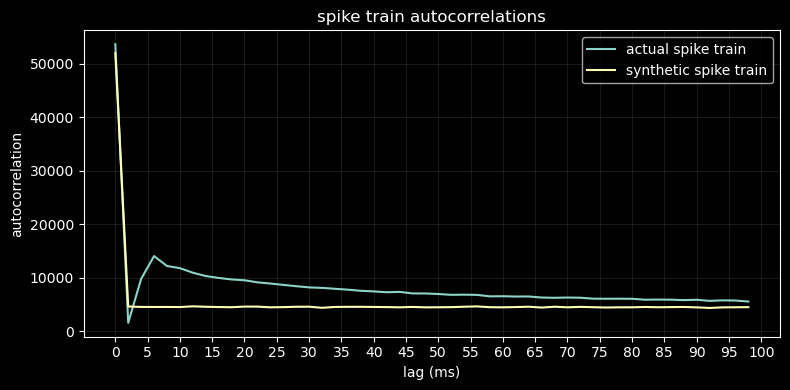

In [229]:
lag_steps = 50
midpoint = len(actual_autocorr)//2
range_start, range_end = midpoint, midpoint + lag_steps
lags = np.arange(0, lag_steps) * dt8 * 1000

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(lags, actual_autocorr[range_start:range_end], label='actual spike train')
ax.plot(lags, syn_autocorr[range_start:range_end], label='synthetic spike train')
ax.set_xlabel('lag (ms)')
ax.set_ylabel('autocorrelation')
ax.set_title('spike train autocorrelations')
ax.legend()

xticks = np.arange(0, lags[-1] + 5, 5)  # assuming lags[-1] is your maximum lag in ms
ax.set_xticks(xticks)
ax.grid(which='both', alpha=0.1)
plt.tight_layout()

dip at 2ms likely due to refractory period in actual H1 neurons, no dip at 2ms for the synthetic data that has no refractory period

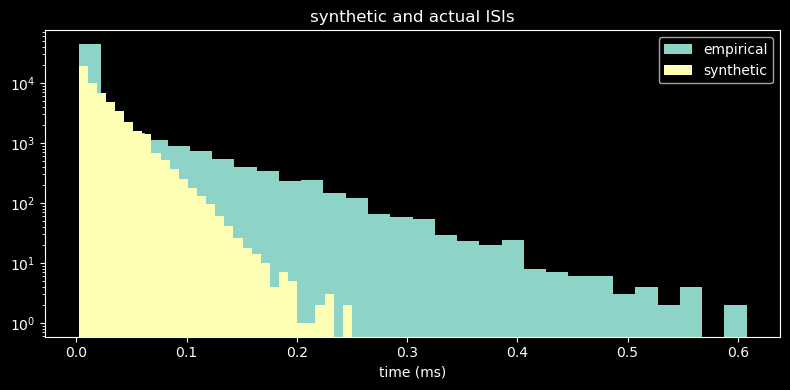

In [266]:
actual_isi = np.diff(h1_times)
syn_isi = np.diff(syn_times)

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(actual_isi, bins=30, label='empirical')
ax.hist(syn_isi, bins=30, label='synthetic')
ax.set_yscale('log')
ax.set_title('synthetic and actual ISIs')
ax.legend()
ax.set_xlabel('time (ms)')

plt.tight_layout()

axis scaling above is likely off by an order in some direction, but dip in empirical ISIs below 0.6 is consistent with question about dip below 6ms
- refractoriness again? could be relative refractory period (not absolute like 2ms?)

In [267]:
# coefficients of variation
def get_cv(isi):
    return np.std(isi) / np.mean(isi)

actual_cv = get_cv(actual_isi)
syn_cv = get_cv(syn_isi)
print(f'actual cv: {actual_cv}\nsynthetic cv: {syn_cv}')

actual cv: 2.0085523370640965
synthetic cv: 0.9685497492751827


synthetic CV is around 1 while empirical CV is larger
- higher variability in ISIs, likely to non-poissonianism in neuron responses, biological factors etc
- synthetic is consistent with poisson process

### 3
file `c2p3.mat` contains responses from cat LGN cell to 2D visual images 
- `counts` is vector containin number of spikes in each 15.6ms bin
- `stim` contains 32767 16x16 images presented at the corresponding time
    - specifically, `stim(x, y, t)` is the stimulus present at coordinate `(x,y)` at time `t`
- calculate STA images for each of the 12 time steps before each spike and show them 
    - time bins can contain more than one spike, so STA must be computed by weighting each stimulus by number of spikes in the corresponding time bin
        - instead of weighting it by 1 or 0 depending on spike presence
    -  in averaged images, should see a central receptive field that reverses sign over time
    - produce image like 2.25C by summing images across one spatial dimension

In [279]:
# get data
import scipy.io
mat = scipy.io.loadmat('data/c2p3.mat')

In [284]:
counts = mat['counts'].flatten()
stim = mat['stim']

In [323]:
bin_size = 15.6
time_window = 100
time_steps = 12

In [327]:
def get_sta(stim, counts, time_steps):
    total_spikes = np.sum(counts)
    sta = np.zeros((16, 16, time_steps))

    for ii in range(time_steps, len(counts)):
        if counts[ii] > 0:
            for jj in range(time_steps):
                sta[:, :, jj] += stim[:, :, ii - jj - 1] * counts[ii]
    
    sta /= total_spikes
    return sta

def spatial_sta_sum(sta, axis=0):
    return np.sum(sta, axis=axis)


In [328]:
sta = get_sta(stim, counts, time_steps)
summed_sta = spatial_sta_sum(sta, 0)

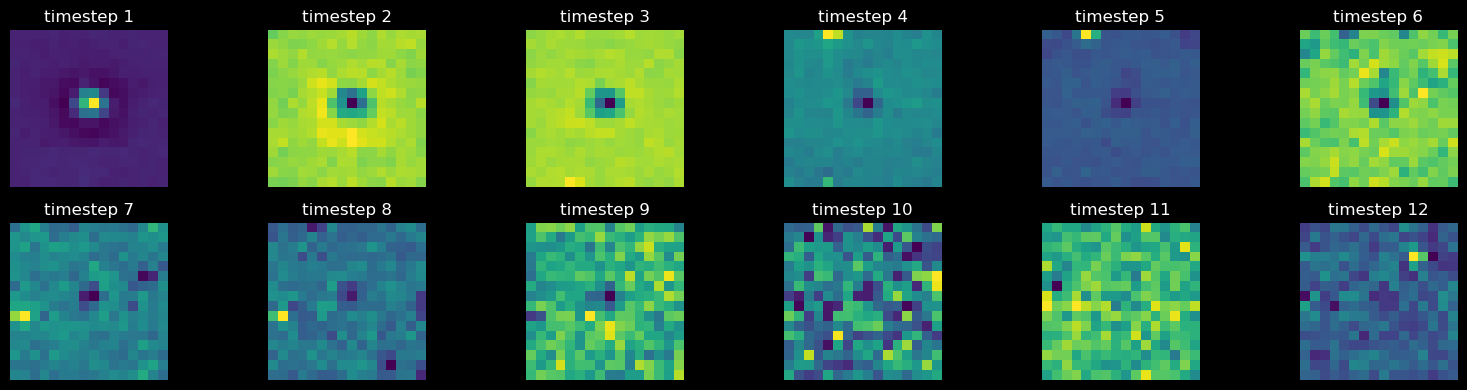

In [364]:
# plot at each timepoint
fig, axes = plt.subplots(2, 6, figsize=(16, 4))

for i in range(12):
    ax = axes[i//6][i%6]
    ax.imshow(sta[:, :, i])
    ax.set_title(f'timestep {i+1}')
    ax.axis('off')

plt.tight_layout()

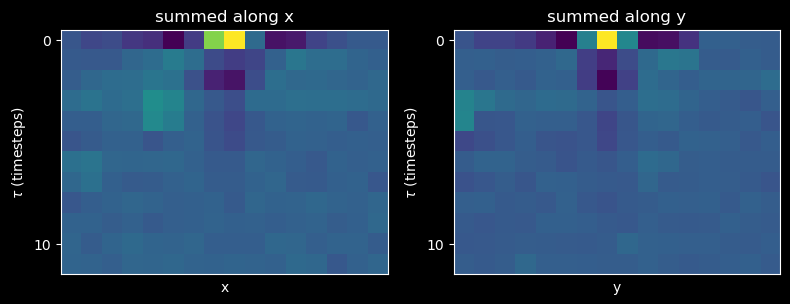

In [395]:
# sum across each spatial dimension
summed_x = spatial_sta_sum(sta, 0)
summed_y = spatial_sta_sum(sta, 1)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(summed_x.T)
ax[0].set_title('summed along x')
ax[0].set_xlabel('x')
ax[0].set_ylabel(r'$\tau$ (timesteps)')
ax[0].set_xticks([])
ax[0].set_yticks([0, 10])
ax[1].imshow(summed_y.T)
ax[1].set_title('summed along y')
ax[1].set_xlabel('y')
ax[1].set_ylabel(r'$\tau$ (timesteps)')
ax[1].set_xticks([])
ax[1].set_yticks([0, 10])
plt.tight_layout()


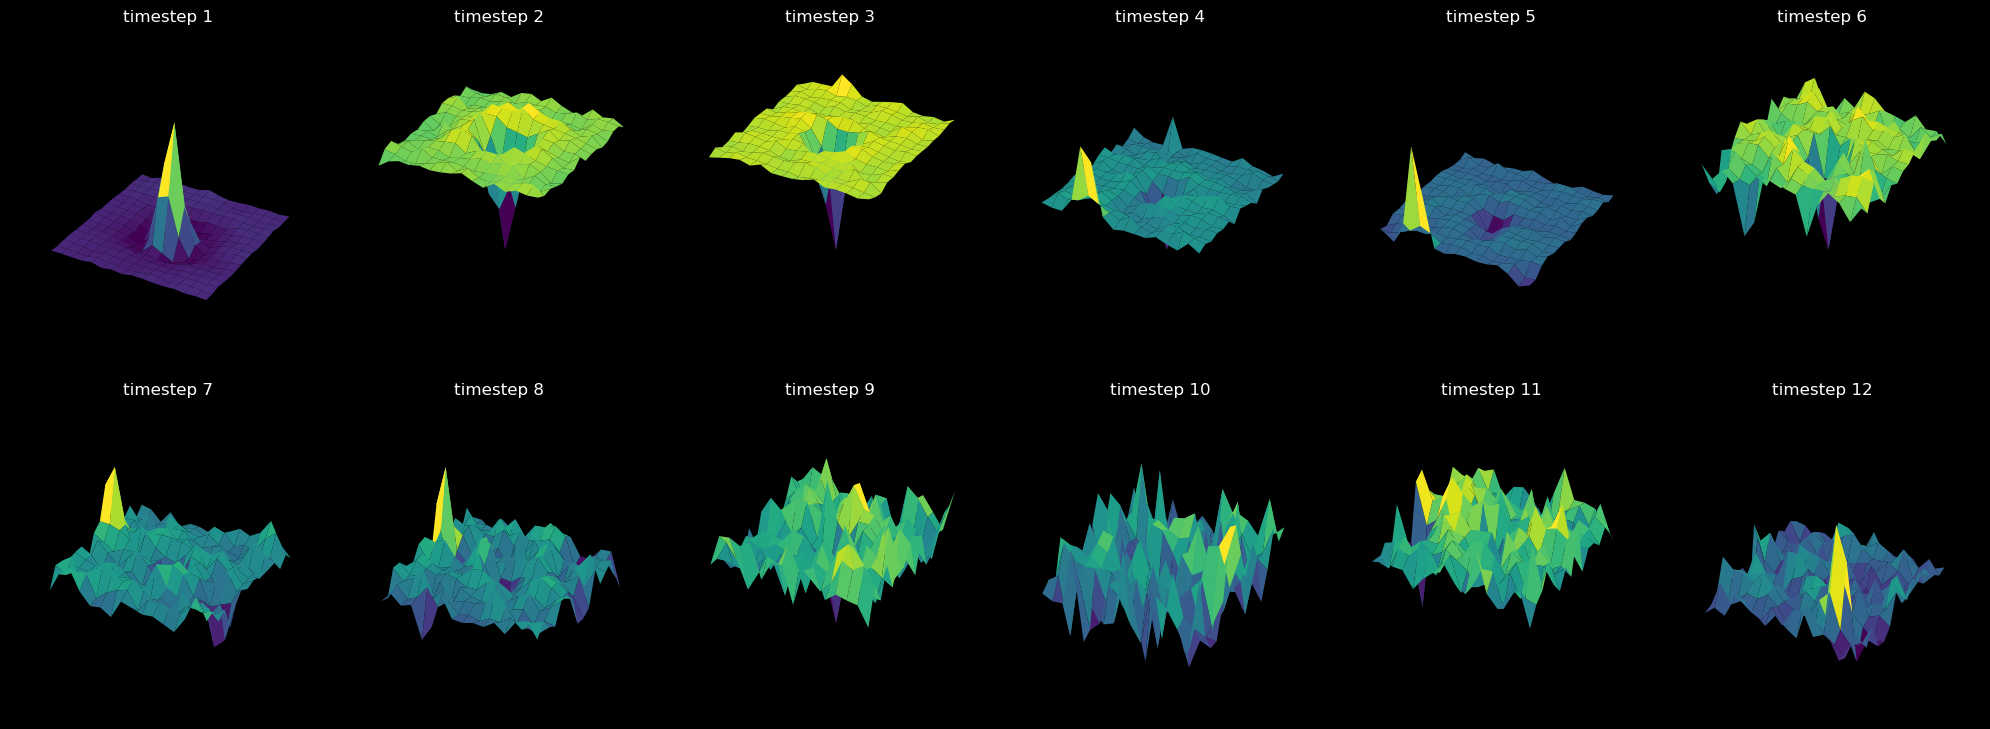

In [407]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_sta(sta, time_steps):
    x = np.arange(sta.shape[0])
    y = np.arange(sta.shape[1])
    X, Y = np.meshgrid(x, y)


    fig = plt.figure(figsize=(20, 8))

    for i in range(time_steps):
        ax = fig.add_subplot(2, 6, i//6 * 6 + i%6 + 1, projection='3d')
        ax.plot_surface(X, Y, sta[:, :, i], cmap='viridis')
        ax.set_title(f'timestep {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_3d_sta(sta, time_steps)

### 5


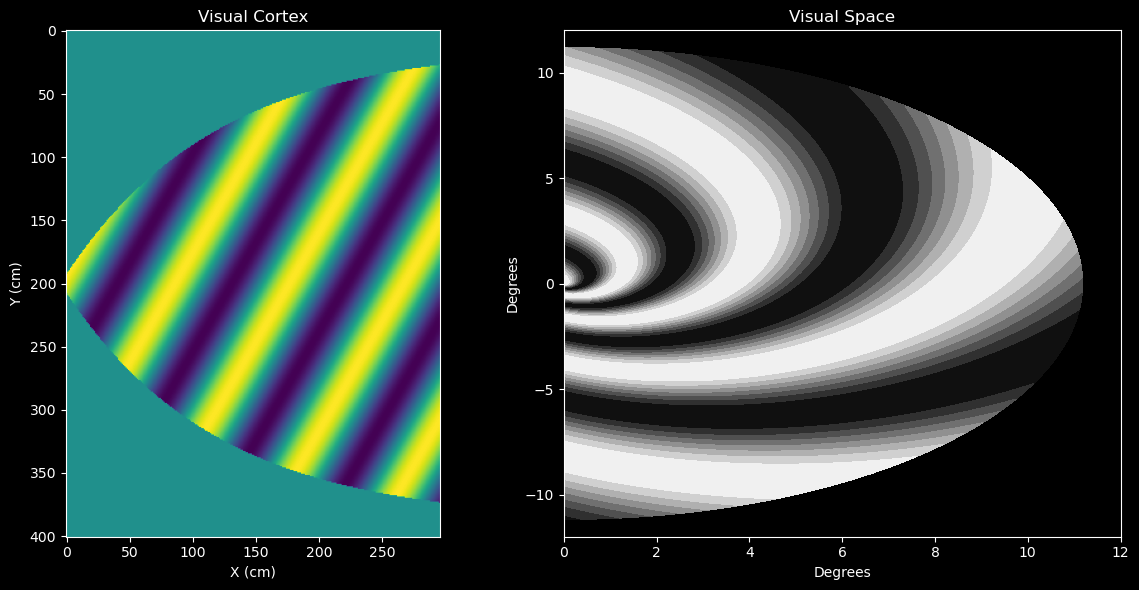

In [417]:
# code from c2p5.m converted to python

lam = 1.2
ep0 = 1.0
x, y = np.meshgrid(np.arange(0.05, 3.01, 0.01), np.arange(-2, 2.01, 0.01))

ep = ep0 * (np.exp(x / lam) - 1)
a = -(180 * (ep0 + ep) * y) / (lam * ep * np.pi)
a = np.where(np.abs(a) < 90, a, 90 * np.sign(a))

in_mask = np.abs(a) < 90

K = 8
Theta = np.pi / 6
Phi = 0
s = np.cos(K * x * np.cos(Theta) + K * y * np.sin(Theta) - Phi)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
ax0.imshow(s * in_mask)
ax0.set_title('Visual Cortex')
ax0.set_xlabel('X (cm)')
ax0.set_ylabel('Y (cm)')

# Visual space pattern
ax1.contourf(ep * np.cos(a * 2 * np.pi / 360), ep * np.sin(a * 2 * np.pi / 360), s, cmap='gray')
ax1.set_xlim(0, 12)
ax1.set_ylim(-12, 12)
ax1.set_title('Visual Space')
ax1.set_xlabel('Degrees')
ax1.set_ylabel('Degrees')

plt.tight_layout()
plt.show()
